### ECG - Datasets and Embeddings - Update 30 April

In this notebook we will build and demonstrate the methods that help use with creating a synthetic dataset.

- Timeseries encoding
- Generate noisy samples
- Preprocessing
- Additional datasets

In [2]:
import torch
import wfdb
import os
import sys
import wfdb
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import stft
from scipy import signal
from scipy.signal import resample
from wfdb import processing

print('Virtual Environment:')
print(sys.prefix)


Virtual Environment:
/Users/piedeboer/Desktop/Thesis/code/signal-denoising/venv


Auxiliary methods for visualization.

In [2]:
def plot_multiple_timeseries(signals, names):
    num_signals = len(signals)
    
    plt.figure(figsize=(5 * num_signals, 4))

    for i, (signal, name) in enumerate(zip(signals, names), 1):
        plt.subplot(1, num_signals, i)
        plt.plot(signal)
        plt.title(name)
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

def visualize_tensor(tensor):
    print('Shape', tensor.shape)

    # Convert the tensor to a NumPy array
    image_array = tensor.numpy()

    # Transpose the array to (H, W, C) format
    image_array = image_array.transpose(1, 2, 0)

    # Display the image using Matplotlib
    plt.imshow(image_array)
    plt.axis('off')  # Turn off axis
    plt.show()

#### Timeseries Encoding
We can use an alternative approach from this paper (https://arxiv.org/pdf/1506.00327.pdf) also used in a paper that used diffusion models to generate ECG signals (https://arxiv.org/pdf/2303.02475.pdf).

Further researched in this paper (https://www.researchgate.net/figure/Conceptual-block-diagram-of-the-proposed-structure-for-individual-household-power_fig4_338359485)

Not Investigated:
- recurrence plots

-------- 
TLDR: 

<font color='lime'>Gramian Angular Fields (GAF)</font> 

**GAF**
- simplified version
- no 3 channels, only GASF
- implemented from scratch (no need for MTF library I don't trust)

In [3]:
# Optimized... (AGAIN) : https://janhendrikewers.uk/exploring_faster_np_clip
def rescale_time_series(X, VMIN=-1, VMAX=1):
    """
    Rescale the time series X to fall within the interval [-1, 1].

    Parameters:
    X (array-like): The input time series.
    VMIN (float): Minimum value for rescaling.
    VMAX (float): Maximum value for rescaling.

    Returns:
    X_rescaled (array-like): The rescaled time series.
    """
    # Min-Max scaling:
    # https://github.com/devitrylouis/imaging_time_series/blob/master/gramian_angular_field.py
    min_ = np.amin(X)
    max_ = np.amax(X)
    scaled_serie = (2 * X - max_ - min_) / (max_ - min_)
    
    # Use np.core.umath.maximum and np.core.umath.minimum for faster rescaling
    X_rescaled = np.core.umath.maximum(np.core.umath.minimum(scaled_serie, VMAX), VMIN)

    return X_rescaled

In [4]:
# Optimized version 
def ecg_to_GAF(X):
    # Rescale
    X = rescale_time_series(X)

    # Calculate the angular values 'phi' using the rescaled time series
    phi = np.arccos(X)

    # Compute GASF matrix
    N = len(X)
    phi_matrix = np.tile(phi, (N, 1))
    GASF = np.cos((phi_matrix + phi_matrix.T) / 2)

    # Return Tensor (1,x,x) for GASF
    x = torch.tensor(GASF).unsqueeze(0)

    return x

def GAF_to_ecg(gaf):

    # print(gaf.shape)
    restored_ecg = gaf.detach().cpu().numpy()
    
    diagonals = np.diagonal(restored_ecg)

    # ecg_tensor = torch.tensor(diagonals)

    return diagonals

torch.Size([1, 256, 256])
Shape torch.Size([1, 256, 256])


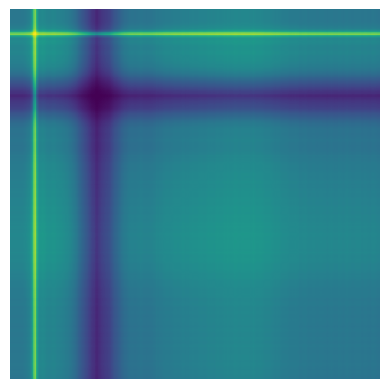

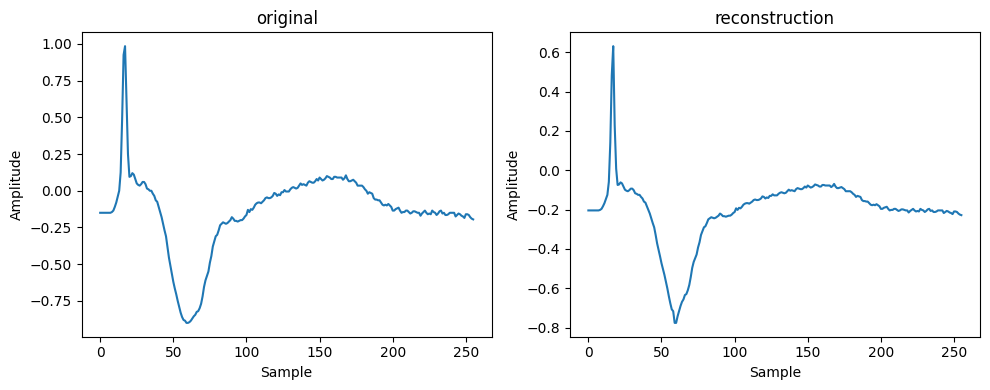

In [5]:
record_102 = wfdb.rdsamp("data/ardb/104", sampto=256)
x = record_102[0][:, 0]

gaf = ecg_to_GAF(x)

print(gaf.shape)
visualize_tensor(gaf)

ecg = GAF_to_ecg(gaf)

plot_multiple_timeseries([x, ecg ], ['original',  'reconstruction'])

#### Generate Noisy Signals

Since our goal is to use a supervised learning (e.g. diffusion image restauration models). We need to build a training/test set.

We can linearly add noise to the samples and control the $SNR$. We use the strategy used in this paper: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9779754. We do not investigate gaussian noise at this this point.

In [6]:
def add_noise(ecg_signal, noise_signal, snr_dB):
    """
    Add noise to the clean ECG signal.

    Parameters:
    - ecg_signal (ndarray): The clean ECG signal.
    - noise_signal (ndarray): The noise signal to be added.
    - snr_dB (float): The desired signal-to-noise ratio in decibels.

    Returns:
    - noisy_signal (ndarray): The noisy ECG signal.
    """
    # Calculate lambda (λ) based on the desired SNR
    lambda_value = np.sqrt(np.mean(ecg_signal**2)) / (np.sqrt(np.mean(noise_signal**2)) * 10**(0.1 * snr_dB / 2))

    # Generate noisy signal
    noisy_signal = ecg_signal + (noise_signal * lambda_value)

    return noisy_signal

#### Preprocesing
One paper that works with 1D CCNs uses a 3.0 sec sliding window : https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9779754. I do assume however, if we want to work with 2D CNNs, we will loose too much detail (does not have to be I guess...).

An altenative approach of researchers that used diffusion models to generate synthetic hearbeats, was to 'split up' the signal into segmeents with just individual heartbeats (https://arxiv.org/pdf/2306.01875.pdf). They did this based on 270 samples, which corresponds to 0.75 seconds, given a sampling rate of 360. However, since certain noise types can clearly affect multiple heartbeats so we might have to find a middle ground. 

-----
TLDR: 
- <font color='lightgreen'>GAF encoding, length 128 samples, EM noise, snr=5 approx ~2 heartbeats at Fs=128 </font> 

Our sample length is $650000$ and based on paper we took $270$ as an 'average' duration for an individual heartbeat.

**Auxilary Methods:** 
- apply 0.5 hz HPF            (baselinewander)
- notch filter for powerline... (powerline interference)
- downsample signal to 128 Hz (domain expert advice)

In [7]:
# Methods
def remove_baseline_wander(ecg_signal, fs):
    # Apply 0.5 Hz High Pass Filter
    cutoff = 0.5  # Hz
    b, a = signal.butter(4, cutoff / (fs / 2), 'high')
    ecg_signal_hpf = signal.filtfilt(b, a, ecg_signal)
    return ecg_signal_hpf
                   
def remove_powerline_interference(ecg_signal, f0, fs):
    # Notch filter to remove powerline interference (assuming 50 Hz)
    f0 = f0  # Hz
    Q = 30.0  # Quality factor
    w0 = f0 / (fs / 2)
    b_notch, a_notch = signal.iirnotch(w0, Q)
    ecg_signal_filtered = signal.filtfilt(b_notch, a_notch, ecg_signal)
    return ecg_signal_filtered

def resample_signal(original_signal, original_fs, target_fs):
    # Calculate the number of samples in the resampled signal
    num_samples_target = int(len(original_signal) * target_fs / original_fs)
    
    # Resample the signal
    resampled_signal = resample(original_signal, num_samples_target)
    
    return resampled_signal

def compute_equivalent_samples(old_num_samples, old_sampling_rate, new_sampling_rate):
    return int(old_num_samples * new_sampling_rate / old_sampling_rate)

In [8]:
# Method to slice the ECG signa
def slice_ecg_signal(ecg_signal, slice_duration):
    ecg_duration = len(ecg_signal)
    num_of_slices = int(ecg_duration / slice_duration)
    slices = []
    for i in range(num_of_slices):
        start_index = i * slice_duration
        end_index = min((i + 1) * slice_duration, ecg_duration)
        slice_data = ecg_signal[start_index:end_index]
        slices.append(slice_data)

    return slices

**How we can build the slices of clean and noisy signals from our training data.**

1. Clean Signals:
- remove baseline wander
- remove powerline interference
- downsample
- generate slice

2. Noisy Samples 1  [add local to slice]
- dowsampled EM noise
- pick random 192 sampels of it
- add to clean slice

Alterantive would be to add the noise to the full length signal and then chop it up. Or.. always add the same 192 samples of the baselinwander.. (generalizability model crap).

In [9]:
# Parameters
signal_length = 650000                        # length ardb and nstdb signals
heartbeat_duration = int(270 * (128/360))     # adjusted for downsampling from 360 Hz -> 128 Hz
k = 2                                         # num of heartbeats

slices_duration = heartbeat_duration*k        # approx 192 :)

# Set a random seed for reproducibility
np.random.seed(42)

# # Function to read ECG signals from .dat files and generate slices
def generate_slices(path_to_ecg_database, path_to_noise_record):
    
    # Dictionaries
    slices_dict_clean = {}
    slices_dict_noisy = {}

    # Length of slice
    sampto = 192

    # Load noise sample
    record_em = wfdb.rdsamp(path_to_noise_record)
    noise_em = record_em[0][:, 0]
    noise_em = resample_signal(noise_em, 360, 128)

    # Iterate over records
    for file_name in os.listdir(path_to_ecg_database):          
        if file_name.endswith('.dat'):
            
            # LOAD RECORD
            record_number = file_name.split('.')[0]
            record = wfdb.rdsamp(os.path.join(path_to_ecg_database, record_number))
            ecg_signal = record[0][:, 0]

            # CLEAN ORIGINAL SIGNAL AND DOWNSAMPLE
            ecg_signal_hpf = remove_baseline_wander(ecg_signal, fs=360)
            ecg_signal_clean = remove_powerline_interference(ecg_signal_hpf, f0=50, fs=360)
            ecg_signal_clean_down = resample_signal(ecg_signal_clean, 360, 128)

            # BUILD SLICES
            clean_slices = slice_ecg_signal(ecg_signal_clean_down, slice_duration=sampto)

            # NUMBER OF CLEAN SLICES
            num_of_slices = len(clean_slices)

            # Add noise to each slice and save as slices_dict_noisy
            noisy_slices = []

            for idx in range(num_of_slices):
                # Generate a random start index within the electrode motion noise signal
                start_index = np.random.randint(0, len(noise_em) - sampto)
                
                # Extract a random part of the noise signal
                random_part_of_noise = noise_em[start_index:start_index + sampto]
                
                # Add noise to the clean slice using the random part of noise
                noisy_slice = add_noise(clean_slices[idx], random_part_of_noise, 3)  # Assuming SNR of 5
                noisy_slices.append(noisy_slice)
                
            slices_dict_clean[record_number] = clean_slices
            slices_dict_noisy[record_number] = noisy_slices

    return slices_dict_clean, slices_dict_noisy

We now build the slices for the **ardb** database. 

In [ ]:
# Folder path containing the .dat files
path_to_ecg_database = "data/ardb"
path_to_noise_record = "data/nstdb/em"

# Generate slices and create dictionary
slices_dict_clean, slices_dict_noisy = generate_slices(path_to_ecg_database, path_to_noise_record)

# Print the dictionary
for record_number, slices in slices_dict_clean.items():
    print(f"Record Number: {record_number}, Number of Slices: {len(slices)}")

plot_multiple_timeseries([slices_dict_clean.get('210')[900], slices_dict_noisy.get('210')[900]], ['Clean', 'Noisy'])

Let us save the slices as a pickle files. Which we can later use to load and then stream to generate GAF embeddings or different embeddings.

In [78]:
# Save 1D signals slices as pickle
def slices_to_pickle(slices_dict_clean, slices_dict_noisy, file_name_clean, file_name_noisy):
    # List
    clean_slices_list = [slices_dict_clean[key] for key in sorted(slices_dict_clean.keys())]
    noisy_slices_list = [slices_dict_noisy[key] for key in sorted(slices_dict_noisy.keys())]

    # Flatten
    clean_slices_flat = [slice for sublist in clean_slices_list for slice in sublist]
    noisy_slices_flat = [slice for sublist in noisy_slices_list for slice in sublist]

    # Pickle
    with open(file_name_clean, 'wb') as f:
        pickle.dump(clean_slices_flat, f)
    with open(file_name_noisy, 'wb') as f:
        pickle.dump(noisy_slices_flat, f)

file_name_clean = 'slices_clean_ardb_fs128.pkl'
file_name_noisy = 'slices_noisy_ardb_fs128.pkl'

Number of noisy samples... mixed noise 57744
Number of clean slices 57744


#### Additional Datasets

**ECG-ID**

Assume we want to obtain a bigger dataset. We can additionaly also process the (filtered) data in the ECG-ID dataset: https://physionet.org/content/ecgiddb/1.0.0/. The dataset contains raw/noisy and filtered samples. The sampling rate is $500 Hz$.

This dataset will be used for:
- Use as real-world dataset (without additional noise added).                        --> unseen data, with likely multiple noise types, data is very raw.
-------

<font color='orange'>Dataset contains some very raw signals. </font> 

<font color='yellow'> Missing ground truth? </font> 

In [1]:
### Example: ECG-ID Dataset ###
record_id_p1_rec_1 = wfdb.rdsamp("data/ecg-id/Person_01/rec_1", sampto=512) 
signal_id_p1_rec_1_noisy = record_id_p1_rec_1[0][:, 0][:512]
signal_id_p1_rec_1_filtered = record_id_p1_rec_1[0][:, 1][:512]

# Obtain sampling rate and compute duration in seconds
num_of_samples = len(signal_id_p1_rec_1_filtered)
sampling_rate = record_id_p1_rec_1[1]['fs']
duration_in_seconds= num_of_samples/sampling_rate

# Display info
print("Sampling rate:", sampling_rate)
print('Number of samples', len(signal_id_p1_rec_1_filtered))
print('Duration in seconds', duration_in_seconds)

# Visualize
plot_multiple_timeseries([signal_id_p1_rec_1_noisy, signal_id_p1_rec_1_filtered], ['Person 1 Rec 1 Noisy (REAL)', 'Person 1 Rec  1 Filtered'])            

NameError: name 'wfdb' is not defined

We can again adapt our method to iterate over the data. This time we will not add noise to the sample. Additionaly, we will not clean the data. We could potenitally use the filtered signal as comparison for ground truth? We directly build two list with slices.

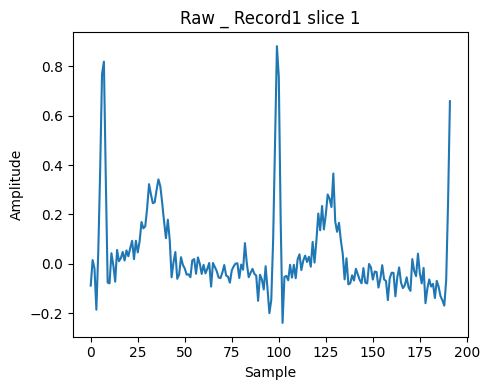

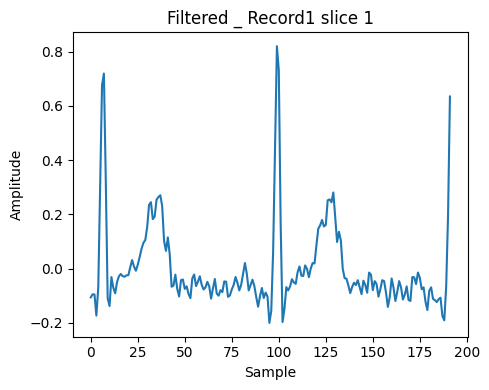

In [26]:
import os
import wfdb

def generate_slices_ecg_id(path_to_ecg_database, limit=20000):
    # List
    list_of_raw_slices = []
    list_of_filtered_slices = []

    # Length of slice
    sampto = 192

    # Counter for limiting files processed
    file_counter = 0

    # Iterate over subfolders sorted from Person_01 to Person_90
    for folder in sorted(os.listdir(path_to_ecg_database)):
        if file_counter >= limit:
            break  # Break the loop if the limit is reached

        # Check if folder is named Person_XX
        if folder.startswith('Person_'):
            folder_path = os.path.join(path_to_ecg_database, folder)

            # print('Foldler path', folder_path)

            # Iterate over files in subfolder
            for file_name in os.listdir(folder_path):
                if file_counter >= limit:
                    break  # Break the loop if the limit is reached

                if file_name.endswith('.dat'):
                    # LOAD RECORD
                    record_number = file_name.split('.')[0]
                    record_path = os.path.join(folder_path, record_number)
                    record = wfdb.rdsamp(record_path)

                    # print('Record number', record_number)

                    # If the record is found
                    if record:
                        ecg_signal_raw = record[0][:, 0]
                        ecg_signal_filtered = record[0][:, 1]

                        # DOWNSAMPLE
                        ecg_signal_raw_down = resample_signal(ecg_signal_raw, 500, 128)
                        ecg_signal_filtered_down = resample_signal(ecg_signal_filtered, 500, 128)

                        # BUILD SLICES
                        slices_raw = slice_ecg_signal(ecg_signal_raw_down, slice_duration=sampto)
                        slices_filtered = slice_ecg_signal(ecg_signal_filtered_down, slice_duration=sampto)

                        # BUILD DICT
                        list_of_raw_slices.append(slices_raw)
                        list_of_filtered_slices.append(slices_filtered)

                        file_counter += 1

    return list_of_raw_slices, list_of_filtered_slices

path_to_ecg_database = 'data/ecg-id'
list_of_raw_slices, list_of_filtered_slices = generate_slices_ecg_id(path_to_ecg_database,20000)

x = int(np.random())       # record x  (TOTAL=)
y = 1       # slice number y

plot_multiple_timeseries([list_of_raw_slices[x][y]], ['Raw _ Record' + str(x) + ' slice ' + str(y)])
plot_multiple_timeseries([list_of_filtered_slices[x][y]], ['Filtered _ Record' + str(x) + ' slice ' + str(y)])

# TODO: flatten the data

**PTB-XL**

We can use an alternative dataset, which might be of better quality. This is the PTB-XL dataset: https://physionet.org/content/ptb-xl/1.0.3/. We downloaded this dataset on Keggle via this link: https://www.kaggle.com/datasets/bjoernjostein/ptbxl-electrocardiography-database.

This dataset will be used:
- Pre-processed with synthetic noise added 
- Raw with synthetic noise added  --> this allows us to see if the model can handle multiple noise types at once (in a supervised manner)

Length of HR1 5000
Length of HR1 Resample Scipy 3600


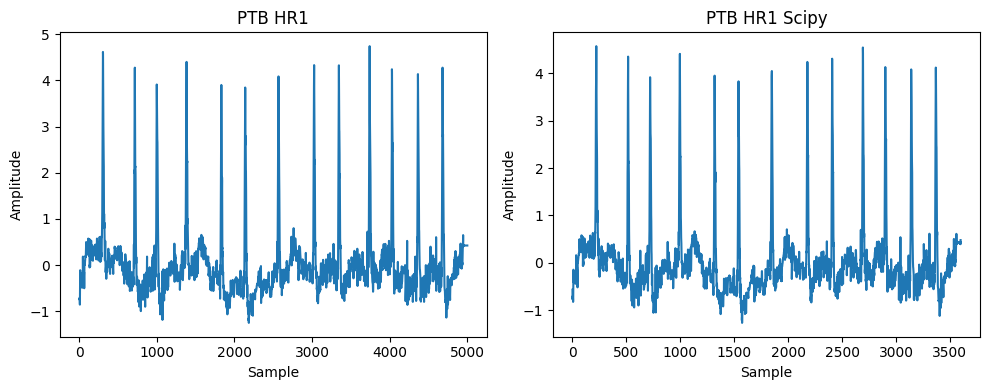

In [98]:
### Example: PTB-XL Dataset ###
record_ptb_HR1 = wfdb.rdsamp("data/PTB-XL/HR10323")
signal_ptb_HR1 =  record_ptb_HR1[0][:, 0]

# Original sampling rate
original_sampling_rate = 500  # Hz

# Target sampling rate
target_sampling_rate = 360  # Hz

# Resample the signal
num_samples_target = int(len(signal_ptb_HR1) * target_sampling_rate / original_sampling_rate)
resampled_signal_ptb_HR1 = resample(signal_ptb_HR1, num_samples_target)

print('Length of HR1', len(signal_ptb_HR1))
print('Length of HR1 Resample Scipy', len(resampled_signal_ptb_HR1))

plot_multiple_timeseries([signal_ptb_HR1, resampled_signal_ptb_HR1], ['PTB HR1','PTB HR1 Scipy'])

In order to not use every file, we wrote an updated, iterate over slices method. We must change $fs$ to $500$, since this was the original sample rate use in this dataset.

In [ ]:
def generate_slices(path_to_ecg_database, path_to_noise_record, limit=20000):
    # Dictionaries
    slices_dict_clean = {}
    slices_dict_noisy = {}

    # Length of slice
    sampto = 192

    # Load noise sample
    record_em = wfdb.rdsamp(path_to_noise_record)
    noise_em = record_em[0][:, 0]
    noise_em = resample_signal(noise_em, 500, 128)      

    # Counter for limiting files processed
    file_counter = 0

    # Iterate over records
    for file_name in os.listdir(path_to_ecg_database):
        if file_counter >= limit:
            break  # Break the loop if the limit is reached

        if file_name.endswith('.dat'):
            # LOAD RECORD
            record_number = file_name.split('.')[0]
            record = wfdb.rdsamp(os.path.join(path_to_ecg_database, record_number))
            ecg_signal = record[0][:, 0]

            # CLEAN ORIGINAL SIGNAL AND DOWNSAMPLE
            ecg_signal_hpf = remove_baseline_wander(ecg_signal, fs=500)
            ecg_signal_clean = remove_powerline_interference(ecg_signal_hpf, f0=50, fs=500)
            ecg_signal_clean_down = resample_signal(ecg_signal_clean, 500, 128)

            # BUILD SLICES
            clean_slices = slice_ecg_signal(ecg_signal_clean_down, slice_duration=sampto)

            # NUMBER OF CLEAN SLICES
            num_of_slices = len(clean_slices)

            # Add noise to each slice and save as slices_dict_noisy
            noisy_slices = []

            for idx in range(num_of_slices):
                # Generate a random start index within the electrode motion noise signal
                start_index = np.random.randint(0, len(noise_em) - sampto)
                
                # Extract a random part of the noise signal
                random_part_of_noise = noise_em[start_index:start_index + sampto]
                
                # Add noise to the clean slice using the random part of noise
                noisy_slice = add_noise(clean_slices[idx], random_part_of_noise, 3)  # Assuming SNR of 5
                noisy_slices.append(noisy_slice)
                
            slices_dict_clean[record_number] = clean_slices
            slices_dict_noisy[record_number] = noisy_slices

            file_counter += 1

    return slices_dict_clean, slices_dict_noisy

Now, let us build 20.0000 noisy and clean slices, in a dict as before. We can then proceed to save these to two pickle files. This allows us to have two (large) datasets to work with for our model.